# Group Assignment 1

## Game of Life : Implementation with and without DASK

This is an example of Conway's Game of Life implementation in Phyton. Conway's Game of Life is a classic cellular automaton devised by mathematician John Conway in the 1970s. It's a simulation of a grid of cells, where each cell can be in one of two states: alive or dead. The game follows a simple set of rules to determine the state of each cell in the next generation based on its current state and the states of its neighboring cells. Python, a popular and versatile programming language, is often used to implement and visualize this intriguing cellular automaton.

### Python Code

In [ ]:
import sys
import os.path
import time
import numpy as np
import dask
import dask.array as da

from dask.distributed import Client

The code initiates the setup for a data analysis or scientific computing project by importing essential Python libraries and modules. To utilize this code effectively, you should install the required Python packages and libraries, including **numpy** and **dask**.

In [ ]:
def read_grid(input_path, chunksize, data_type):
    
    with open(input_path) as f:
        
        h, w = map(int, f.readline().split())
        
        grid = np.zeros((h, w), dtype = data_type )

        for line in f:
            x, y = map(int, line.split())
            grid[x, y] = 1    

    return grid

The **read_grid** function reads data from a file specified by the input_path and constructs a 2D grid using NumPy, where elements are set to 1 based on the content of the file. The input for this data looks like as follows:<br> 
5 5        <*first row consist of the size of the board*> <br> 
0 0        <*rest is the indicator of living cells*> <br> 
2 1 <br> 
2 2 <br> 
3 2 <br> 
3 4


In [ ]:
def save_grid(grid,output_path):
    with open (output_path, "w") as f:
        h, w = grid.shape
        f.write(f"{h} {w}\n")

        indices_1 = np.argwhere(grid == 1)
   
        for i in indices_1:
            f.write(f"{i[0]} {i[1]}\n")


The save_grid function is designed to save a grid to a file specified by output_path. The output file will have similiar format with the input file.

In [ ]:
def tick(grid_da):
    h, w = grid_da.shape
    temp = np.zeros_like(grid_da)
    neighbors = np.array([
        (-1, -1), (-1, 0), (-1, 1),
        (0, -1),           (0, 1),
        (1, -1),  (1, 0),  (1, 1)
    ], dtype='int8')
    
    for y, row in enumerate(grid_da):
        for x, cell in enumerate(row):
            count = 0
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy
                # if its neighbor doesn't go beyond the boundary and is alive 
                if 0 <= nx < w and 0 <= ny < h and grid_da[ny, nx]==1:
                    count += 1
                      
            if cell:
                cell = 1 if count >= 2 and count <=3 else 0
            else:
                cell = 1 if count == 3 else 0
            
            temp[y, x] = cell
            
    grid_da = temp
    return grid_da

The tick function appears to implement the logic for one iteration or "tick" of the Game of Life. The rules of Conway's Game of Life as folows:
 - Every cell is affected by its surrounding neighbours (horizontaly, vertically, and diagonally.
 - For each generation, every cells will be assessed by its neighbours: 
> - Any live cell with two or three live neighbours survives. <br> 
> - Any dead cell with three live neighbours becomes a live cell. <br> 
> - All other live cells die in the next generation. Similarly, all other dead cells stay dead. <br> 

#### Main Function with DASK

In [ ]:
def main():
    input_path = "benchmark/1000x1000_0.1.txt"
    output_path = "output_test1000x1000.txt"
    generations = 1
    chunksize = (100, 100)
    scheduler = "threads"
    data_type = "int32"
    
    grid = read_grid(input_path, chunksize, data_type)
    grid_da = da.from_array(grid, chunks=(chunksize[0], chunksize[1]))
 
    start = time.time()
    client = Client()
    
    for i in range(generations):
        grid_da = grid_da.map_overlap(tick, depth=1, boundary="none")
        print("{} seconds elapsed for {} generation.".format(round(time.time() - start, 7), i))
    
    grid = grid_da.compute(scheduler=scheduler)
    
    save_grid(grid, output_path)
    client.shutdown()

    print("{} seconds elapsed for all {} generations and saving.".format(round(time.time() - start, 7), generations))

if __name__ == "__main__":
    main()

The main function represents the core logic of the program. It reads an initial grid from a file, applies the "tick" function to simulate the evolution of the grid over multiple generations, and then saves the final grid to an output file. In the DASK implementation, implementation grid_da is creating a Dask array (grid_da) from an existing NumPy array (grid).

#### Main Function **without** DASK

In [ ]:
def main():
    input_path = "test/1000x1000_0.1.txt"
    output_path = "output_test1000x1000.txt"
    generations = 1

    grid = read_grid(input_path, chunksize, data_type)
    
    for i in range(generations):
        grid = tick(grid)

    save_grid(grid, output_path)

if __name__ == "__main__":
    main()

In the non-DASK immplementation, the grid was left as NumPy array. The python file for implementation for bot DASK and non-Dask will be available on the repository.

### Benchmark and Compare

#### Benchmark: Time

A series of benchwark was done to the code using time library. The time was measured by adding this line of code at the main function of phyton code.
> import time
> 
> start_wall_time = time.time()
> start_cpu_time = time.process_time()
<br>
> end_cpu_time = time.process_time()
> end_wall_time = time.time()
><br>   
> print(f"{end_cpu_time - start_cpu_time:.7f} seconds (CPU Time) elapsed for all {generations} generations.")
> print(f"{end_wall_time - start_wall_time:.7f} seconds (Wall Time) elapsed for all {generations} generations and saving.")



The results are as folows: <br>
| Implementation |   Size   | Generation | CPU-Time (1) | Wall time (1) |   Scheduler   |
|-----------------|----------|------------|--------------|---------------|--------------|
|    Non-Dask     | 1000x1000 |     1      |   26.84375   |   45.4273169  |               |
|    Non-Dask     | 1000x1000 |     5      | 182.640625   | 307.1164827  |               |
|      Dask       | 1000x1000 |     1      |   24.34375   |   62.9998982  |   threads     |
|      Dask       | 1000x1000 |     5      | 149.671875   | 383.3413947  |               |
|      Dask       | 1000x1000 |     1      |   25.28125   |   78.9935796  | synchronous   |
|      Dask       | 1000x1000 |     5      | 158.90625    | 448.0422585  |               |
|      Dask       | 1000x1000 |     1      | 0.328125     | 10.14151     | distributed   |
|      Dask       | 1000x1000 |     5      | 4.34375      | 72.4737372   |               |
|      Dask       | 1000x1000 |     50     | 41.234375    | 721.2321131  |               |
|      Dask       | 1000x1000 |     1      | 0.578125     | 8.1834481   | processes     |
|      Dask       | 1000x1000 |     5      | 3.21875     | 40.806279   |      |
|      Dask       | 1000x1000 |     50      | 14.53125     | 204.5440044   |  |


Based on the results in the table, it can be concluded that the Dask implementation with the process scheduler demonstrates the best performance, consistently achieving the lowest Wall Time across various generations of a 1000x1000 grid. Notably, the generation of this grid using the distributed scheduler records the shortest CPU Time, indicating efficient parallelization. However, it's essential to address the discrepancy between CPU Time and Wall Time, which suggests potential issues in the read and save code, affecting the overall efficiency of the task. Note: all of dask operation are done with 100, 100 chunks.

#### Comparisson: cProfiler

To understand what happening between the function a cprofiler are used to see the interaction between function when running the code. To run line profiler, you need to have use terminal by use following commnands:<br>
> python -m cProfile -o output.prof scriptname.py

On your main directory a file with the name of output.prof. 

To visualize it you will also will need another phyton code to visualize the profiling. SnakeVis is used for this documentation. To use SnakeVis, you can use by following comands: <br>
> snakeviz output.prof

At SnakeViz, the aim is to analyse the processing time of specific functions. In the image below, the script is executed without DASK to generate a 1000x1000 board game of life in one generation. The time function embedded within the code indicates 50.8539486 seconds (Wall Time). SnakeViz enables us to infer that the time is predominantly consumed by the tick function in the code.

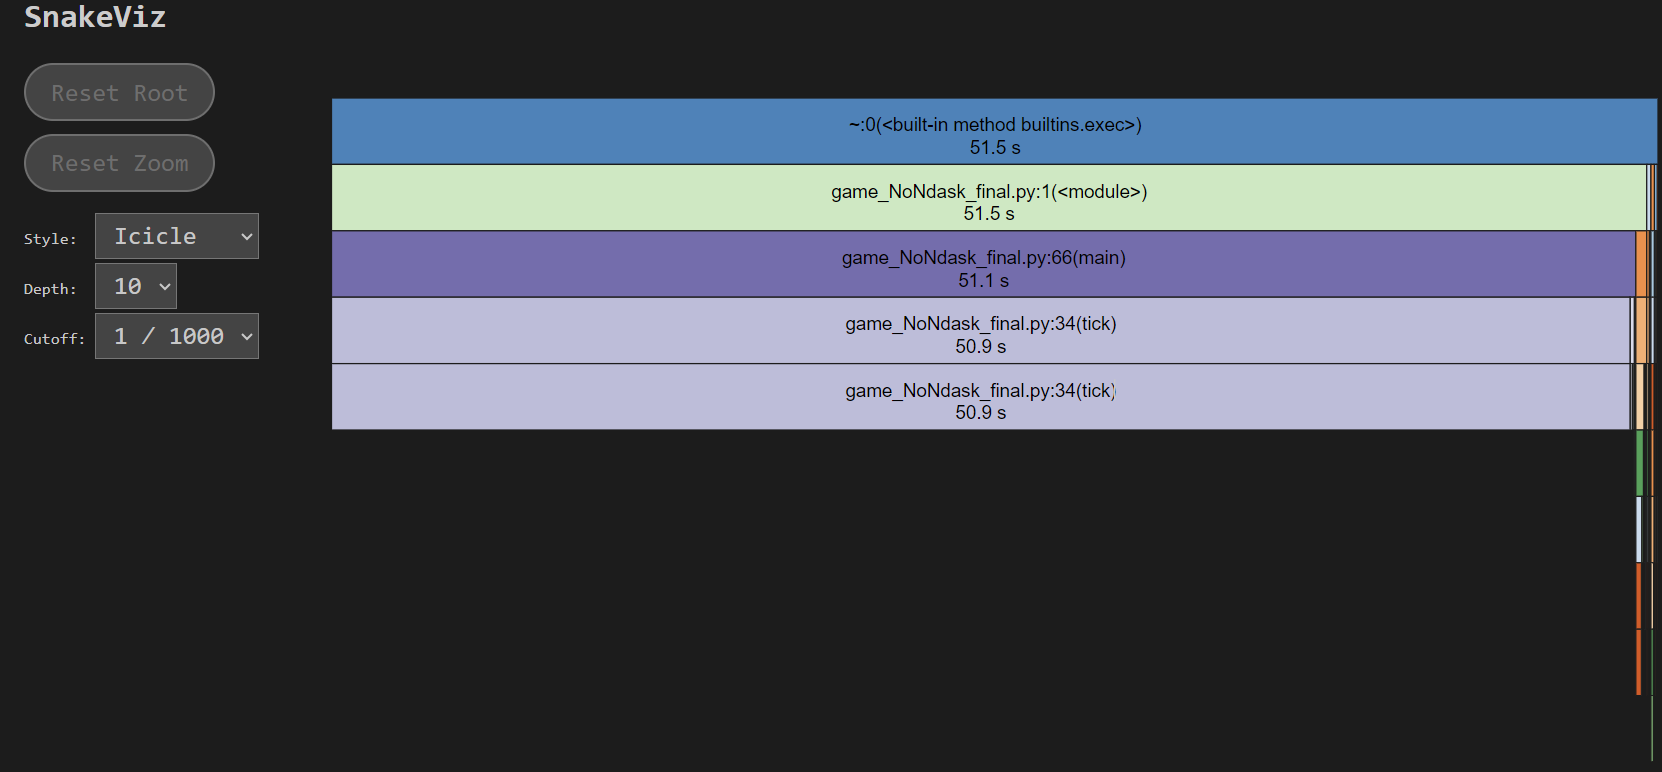


In a single generation, there is not a significant difference between the implementation with and without DASK. In fact, the implementation with DASK by threads took longer, at 67.9572711 seconds (Wall Time). This is because the parallelization for this operation is not suited using thread.

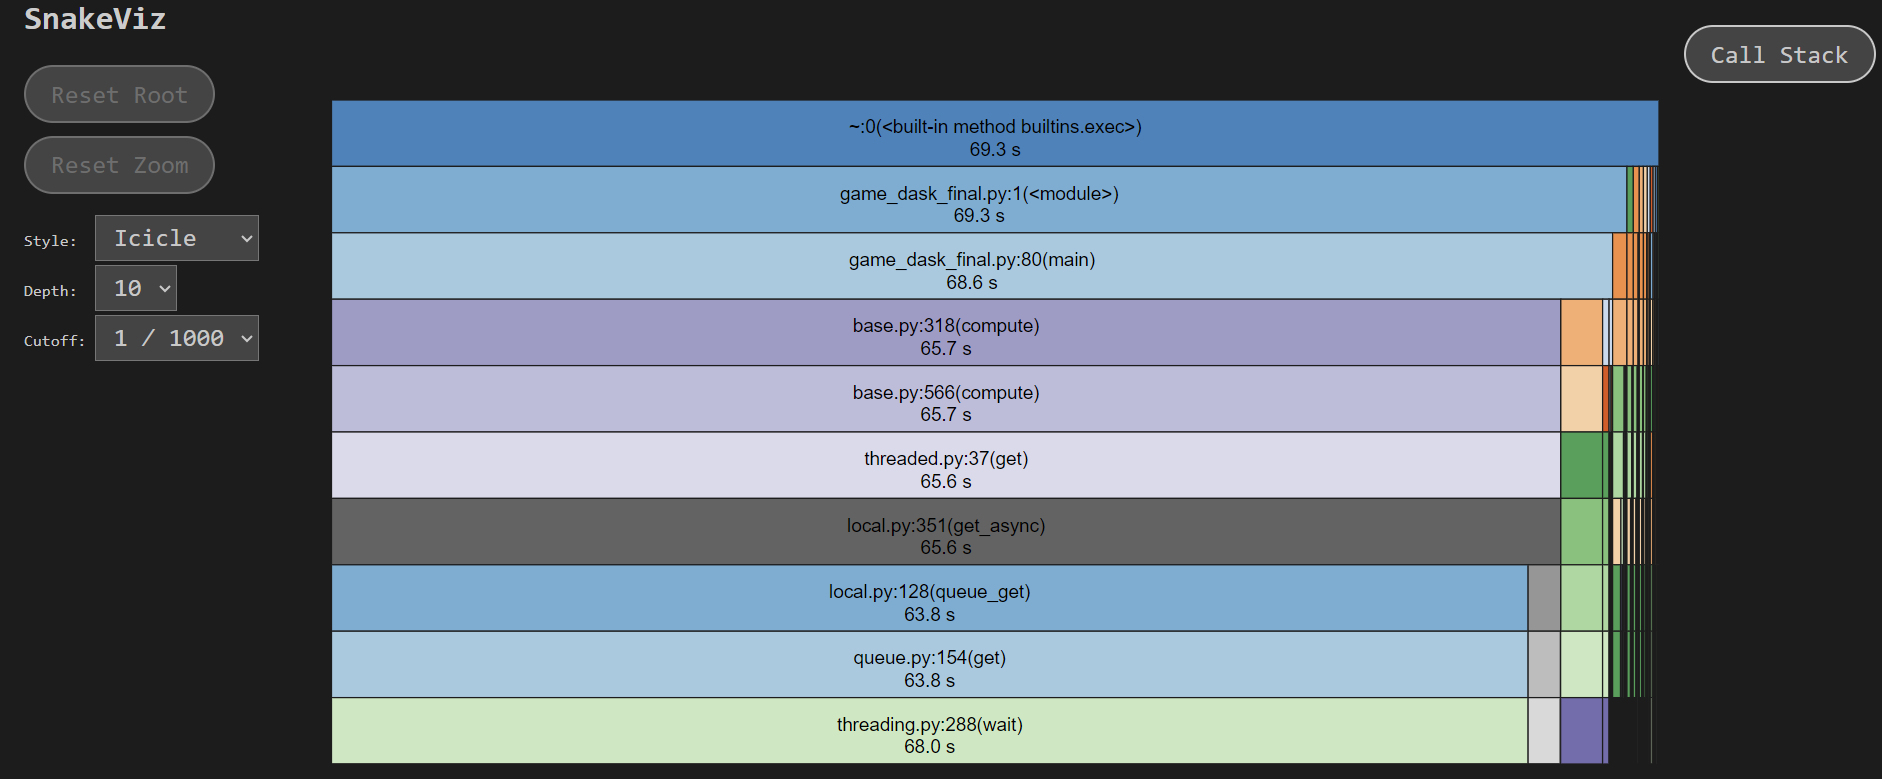

Using the DASK implementation has resulted in a significant decrease in processing time, at 7.8173151 seconds (Wall Time). However, as the processing is being done in parallel, there is not much to be seen on SnakeViz. Furthermore, cprofiler is unable to profile the condition of a function that takes several workers. It should also be noted that the SnakeViz depth here is only 5, in contrast to 10.

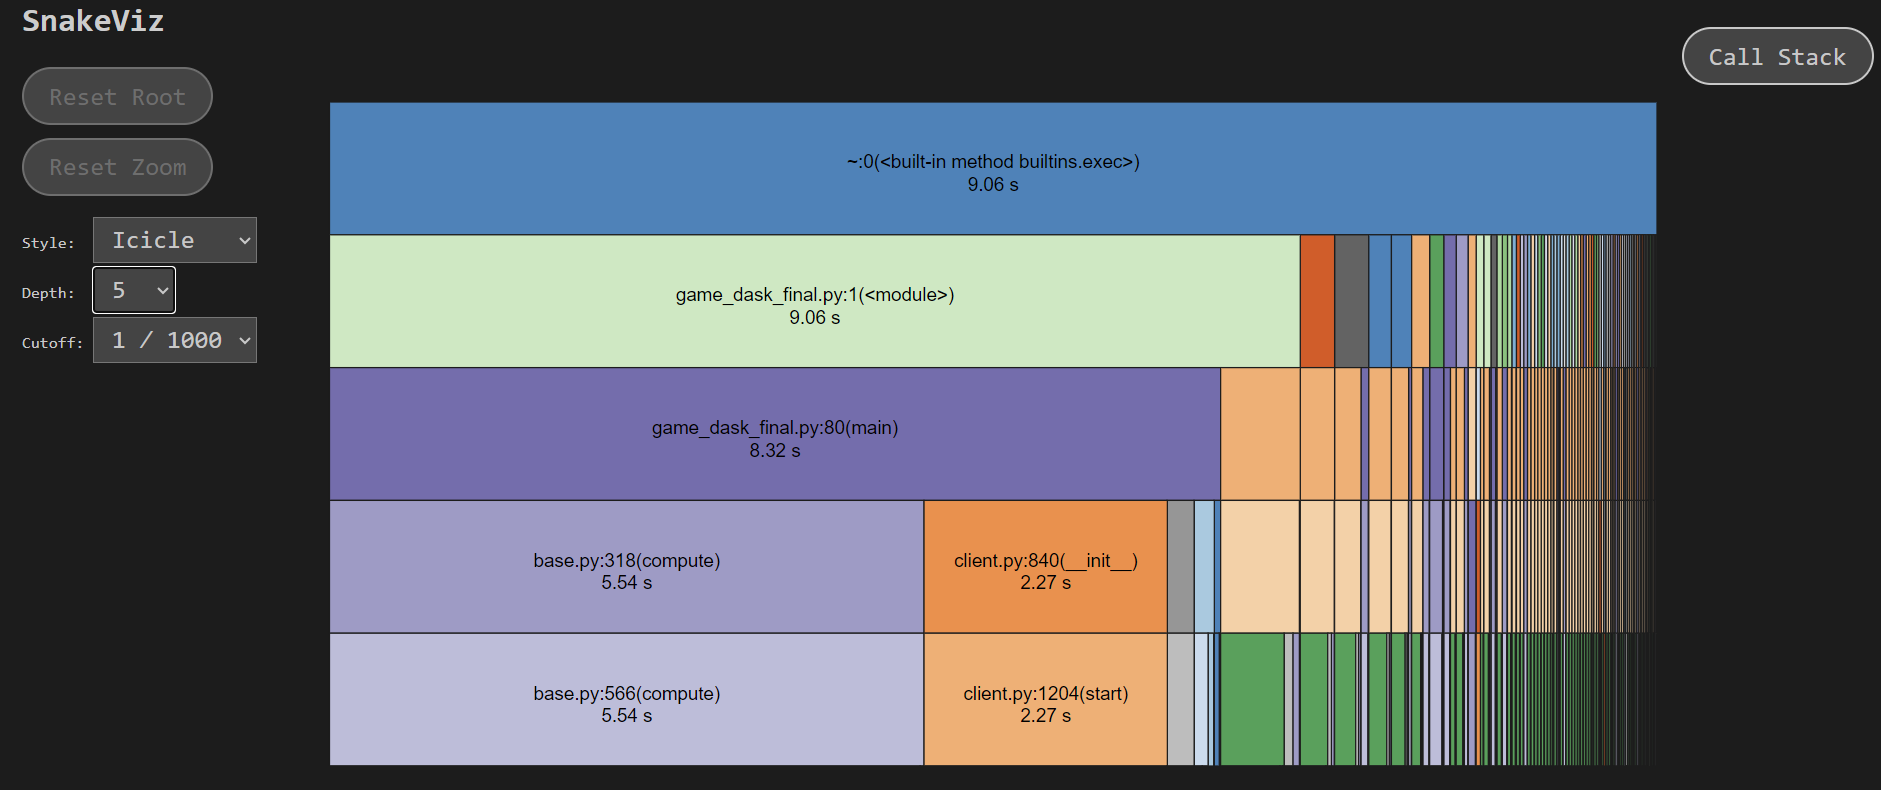

#### Comparisson: Kern Line Profiler (kernprof)

To comprehend the activities at the code level, it is necessary to use a Line Profiler. This documentation employs the Kern Line Profiler to inspect the processes line by line. To interact with the Line Profiler, the script file must be decorated with @Profile and added with the LineProfiler script. The following code should be appended to the script:
>from line_profiler import LineProfiler ##library for lineprofile
>
>@profile       ##before the function that you want to analyze
>
> profile = LineProfiler() ## in the main function <br>
> profile.add_function(save_grid)<br>
> profile.add_function(tick)<br>
>

To run the kern profiler, you will need to use terminal and use this following command:
>kernprof -l scriptname.py <br>

After running this terminal, kernprof will create a new file called scriptname.py.lprof
>
To visualize it, use terminal with the following commands:
> python -m line_profiler -rmt "scriptname.py.lprof"

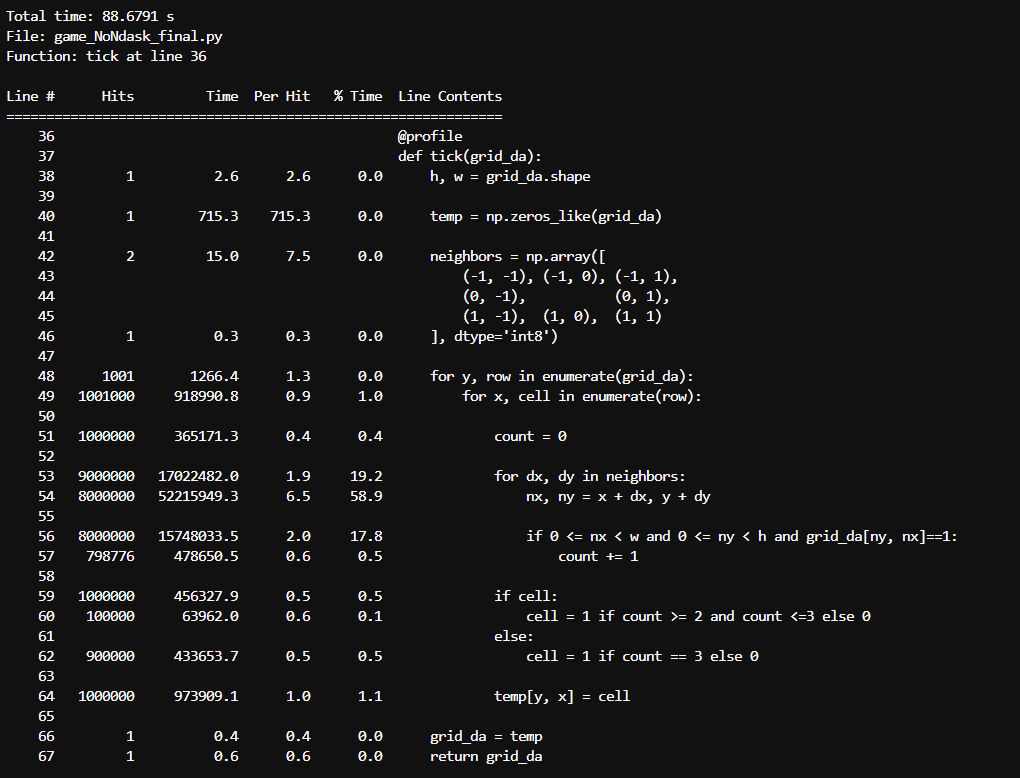

This is a line profile detailing the non-dask implementation of running a 1000x1000 operation with one generation. The line profiler indicates the frequency with which each line was called during the operation. Time refers to the total duration of the process, while Per Hit denotes the time taken for each call. Time refers to the total duration of the process, while Per Hit denotes the time taken for each call. %Time shows the proportion of total time attributed to each line. For instance, line 49 was called 10,000,000 times and took 918990.9 units of time, although each call only used 0.9 units. Based on the output of the kernprofiler, it can be deduced that line 54 consumed the longest time to execute within this function.

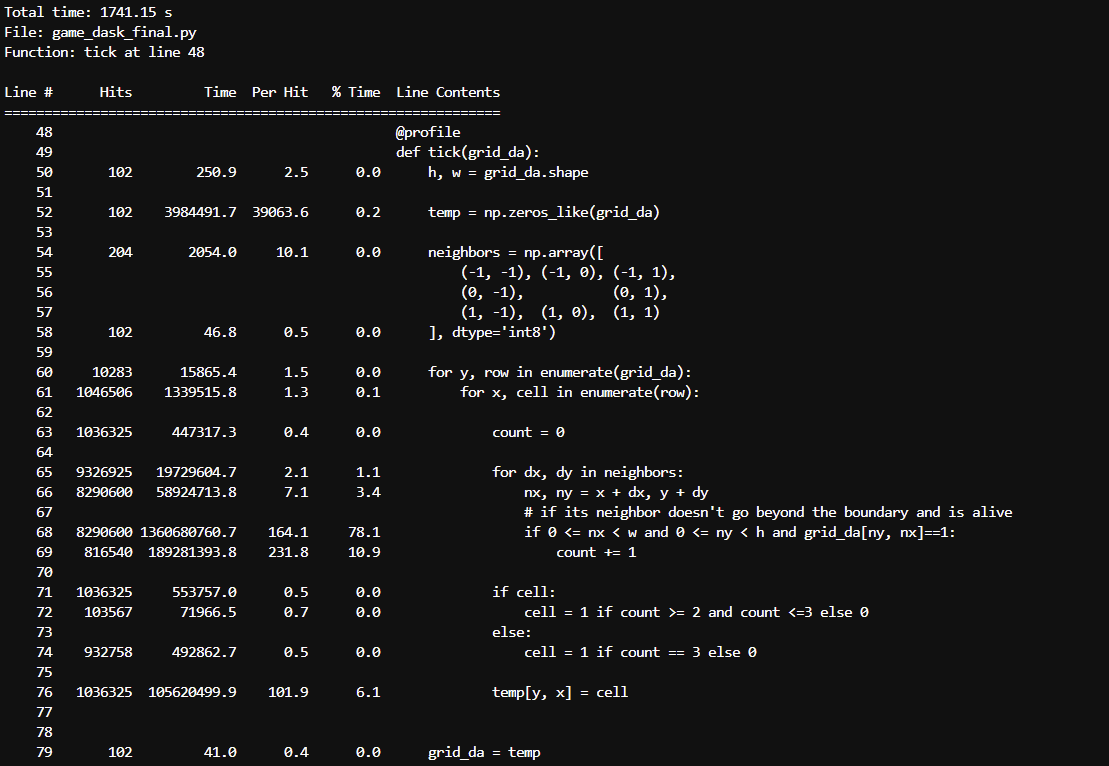


Similar story when illustrating the utilization of the DASK implementation through a thread scheduler. This elucidates the story behind the SnakeViz from the cProfiler. Likewise, the cProfiler also lacks the ability to display Processes line profile since it follows the same principle.

#### Comparisson: Dask Dashboard

The Dask Dashboard is an efficient tool to understand the task stream and monitor ongoing computations. The image below is the dashboard of 1000x1000 grid run for 1 generation. The task processing graph shows the number of workers running (4 in this case) and the proportion of tasks running on each worker. The task strean pannel has 12 rows corresponding to 12 threads. The colored rectangles represent different types of tasks. Red retangles indicate tasks related to communication between workers. In the case of Game Of Life, the red rectangles are too many as the grid is chunked and different workers must communicate often to be able to read the neighbourning cells. White spaces indicate 'dead time', when the workers were idle, or waiting for other computations to complete. Ideally, our script must be optimised to reduce dead time and communication tasks.

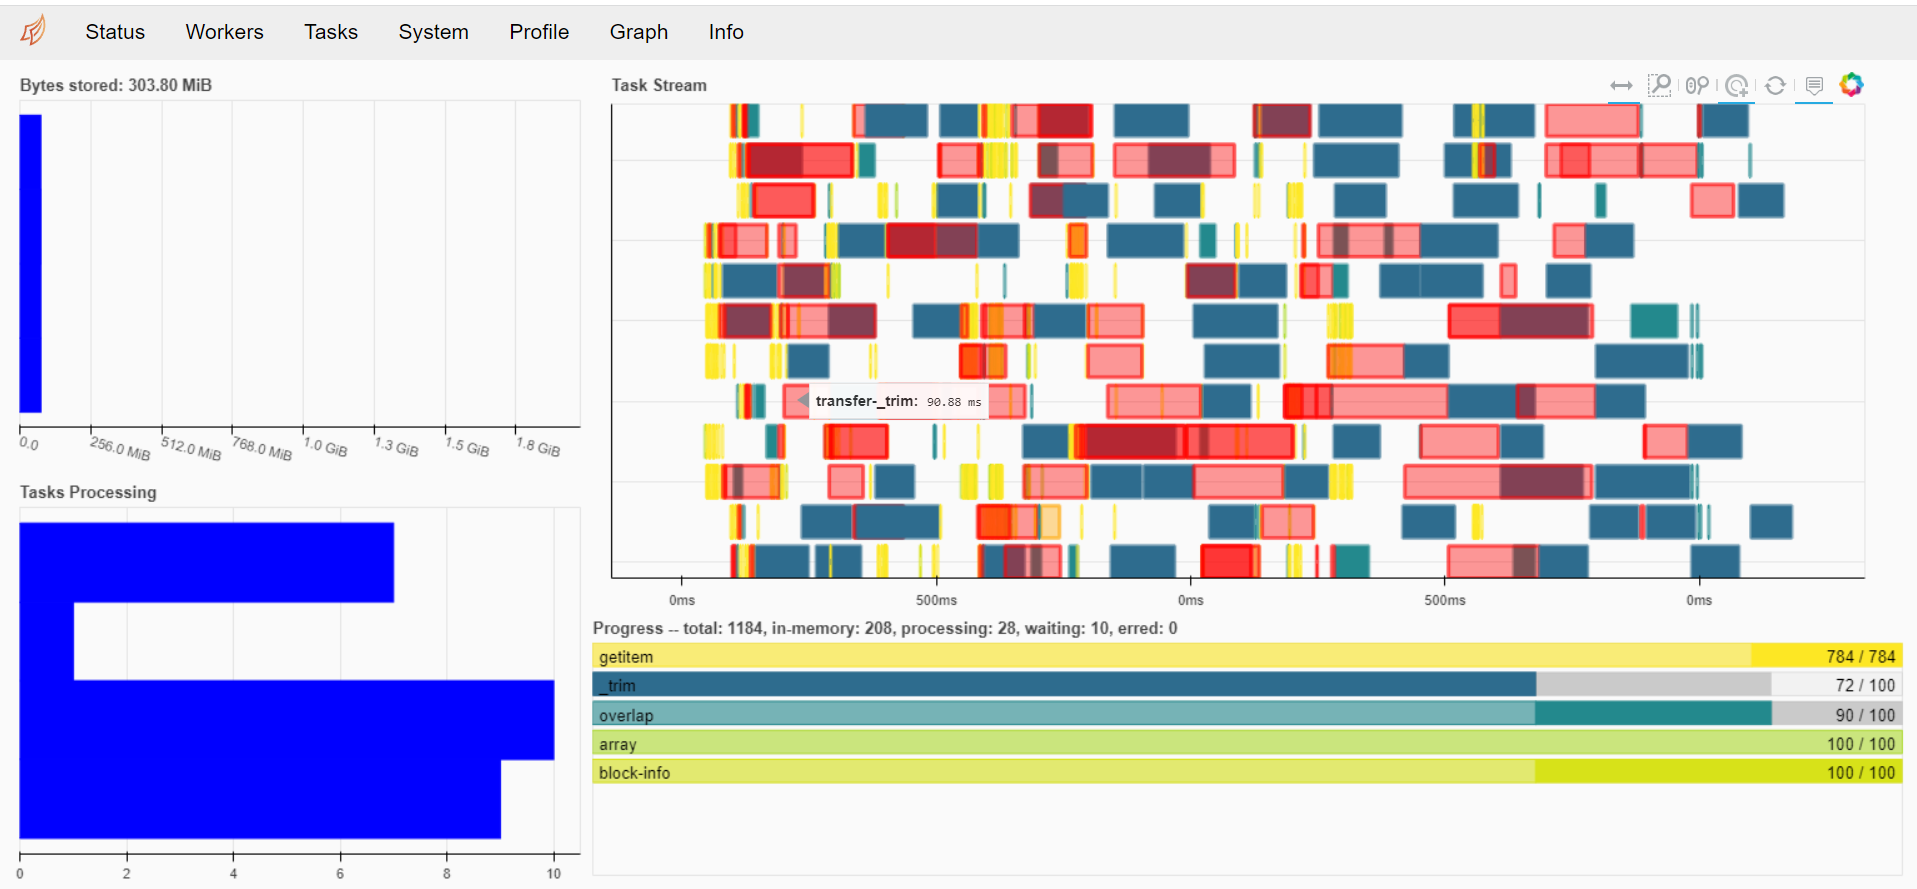

<p style="text-align: center;">Image : 1000 x 1000 grid Dashboard</p>

By increasing the chunk size, the communication between workers can be reduced. This is shown in the example below. On the left a 10000 x 10000 grid is run with chunk size = (1000, 1000). After a while, the same grid is run with chunk size = (2000, 2000). The number of communication tasks are comparatively lesser. However, due to longer dead time the overall Wall Time to run both were almost same.

Among the different kind of tasks shown in the bottom right progress pannel, it can be noted that the 'trim' and 'overlap' tasks take the longest time to compute. This is again a slow down related to the chunking and processing of chunked arrays. These fucntions are within the map_overlay() function used to compute the generations for chunks.

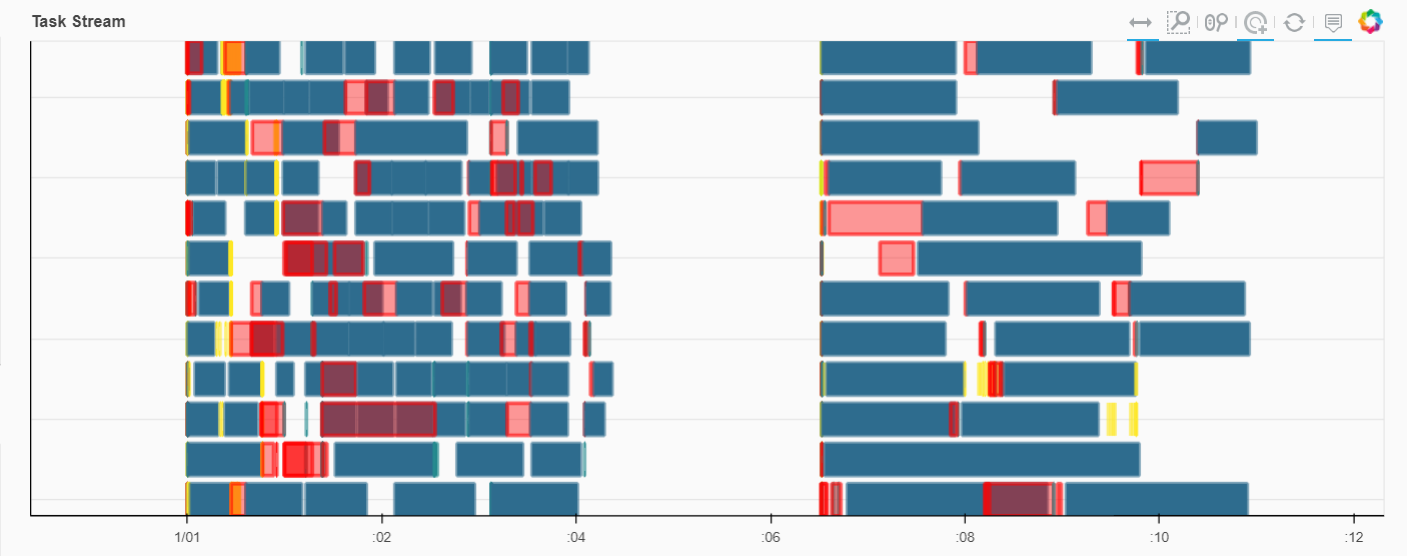

<p style="text-align: center;">Image : 10000 x 10000 grid Task stream</p>

Another interesting feature of the Dash board is the abiltiy to view the Task Graph od distributed processing. Initially, instead of computing the grid after the generations run, we tried to call the compute() on the dask array only while saving the live indices into a file. However as seen from the Task graph, this involved rechunking and an increasing in the size of the task graph (Image a). After this observation, we chose to call compute() after processing the generations and using the computed numpy array to then save the file (Image b).

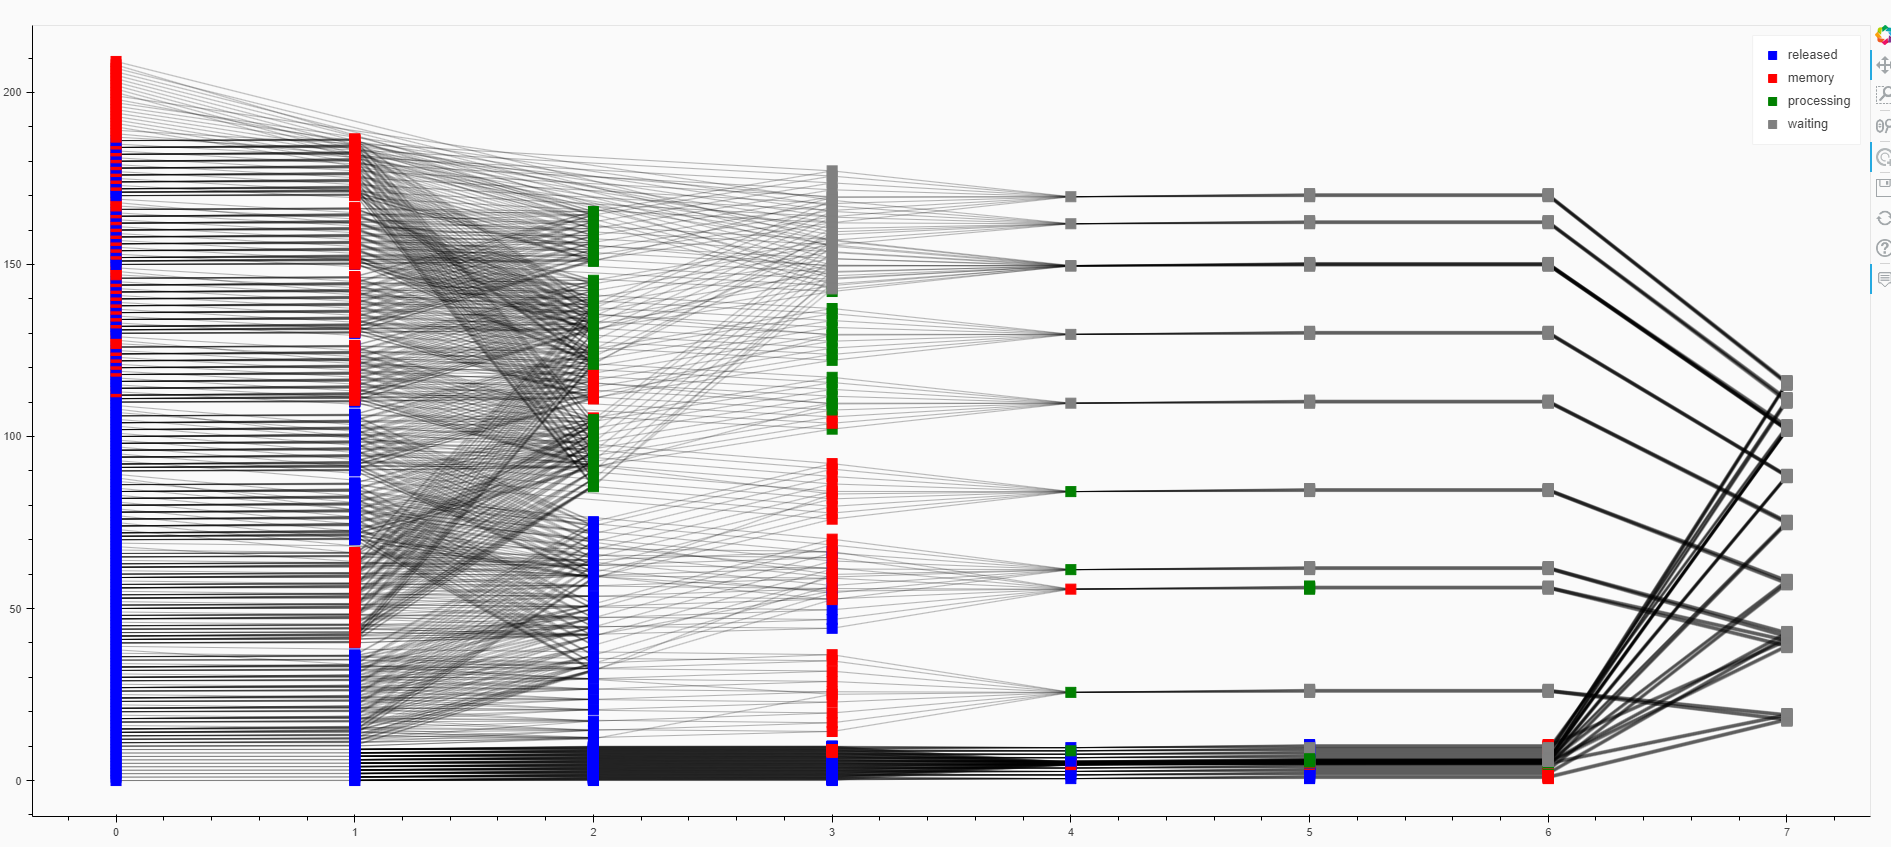

<p style="text-align: center;">Image a</p>

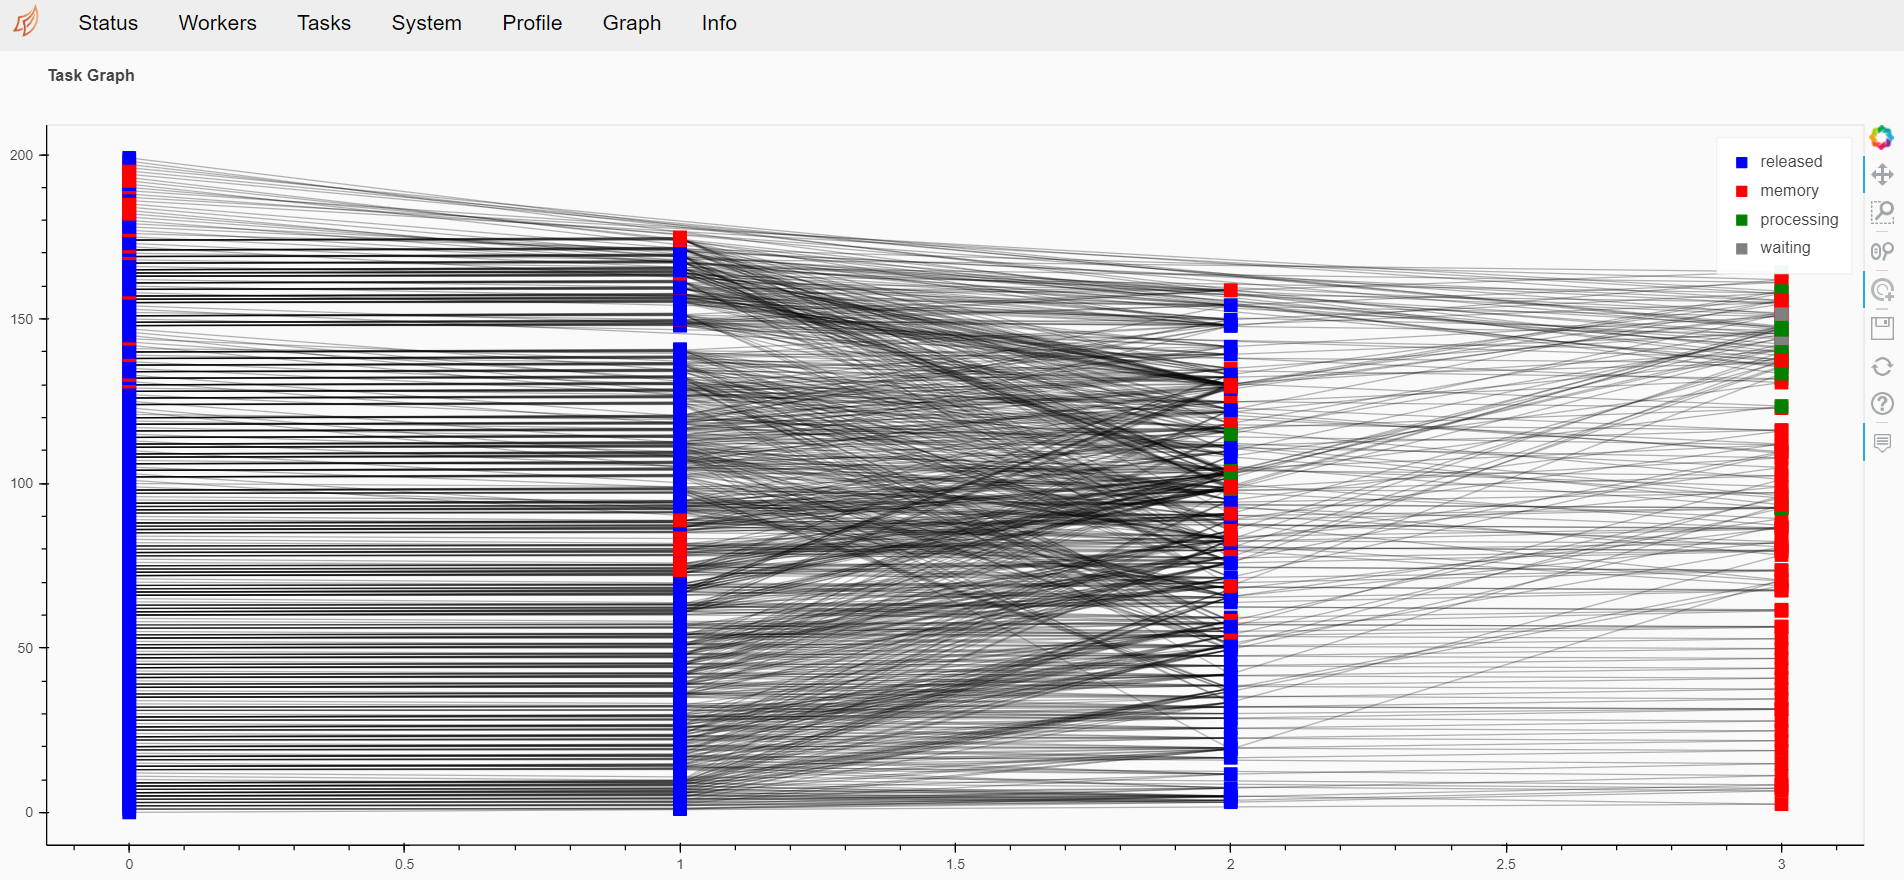

<p style="text-align: center;">Image b</p>

The Dask Dashboard is an efficient tool to understand the task stream and monitor ongoing computations. The image below is the dashboard of 1000x1000 grid run for 1 generation. The task processing graph shows the number of workers running (4 in this case) and the proportion of tasks running on each worker. The task strean pannel has 12 rows corresponding to 12 threads. The colored rectangles represent different types of tasks. Red retangles indicate tasks related to communication between workers. In the case of Game Of Life, the red rectangles are too many as the grid is chunked and different workers must communicate often to be able to read the neighbourning cells. White spaces indicate 'dead time', when the workers were idle, or waiting for other computations to complete. Ideally, our script must be optimised to reduce dead time and communication tasks.

### After Thought

After conducting a benchmark of the script, a new version has been created to address the issue of high processing time in the tick function. The updated script separates the functions to count the neighbors (count_neighbour) and to execute the tick method (tick). It also utilizes the vectorized definition of Conway's Game of Life. This separation is intended to prevent the repetition of neighbor-reading during the counting process. The following is the Python code:

In [ ]:
import sys
import os.path
import random
import time  
import numpy as np
import dask
import dask.array as da

from dask.distributed import Client



def read_grid(input_path, chunksize, data_type):
    
    with open(input_path) as f:
        
        h, w = map(int, f.readline().split())
        
        grid = np.zeros((h, w), dtype = data_type )

        for line in f:
            x, y = map(int, line.split())
            grid[x, y] = 1    
   
    return grid

def save_grid(grid_da,output_path, scheduler):
    with open (output_path, "w") as f:
        h, w = grid_da.shape
        f.write(f"{h} {w}\n")

        indices_1 = np.argwhere(grid_da == 1)
        indices_1 = indices_1.compute(scheduler = scheduler)

        for i in indices_1:
            f.write(f"{i[0]} {i[1]}\n")

import numpy as np

def count_neighbors(grid_da):
    h, w = grid_da.shape
    neighbor_count = np.zeros_like(grid_da, dtype='int32')
    
    for y in range(h):
        for x in range(w):
            count = 0
            for dy in range(-1, 2):
                for dx in range(-1, 2):
                    if dy == 0 and dx == 0:
                        continue 
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < h and 0 <= nx < w:
                        count += grid_da[ny, nx]
            neighbor_count[y, x] = count

    return neighbor_count
    
def tick(grid_da):

    neighbor_count = count_neighbors(grid_da)

    new_grid = (
        (grid_da == 1) & ((neighbor_count == 2) | (neighbor_count == 3)) |
        (grid_da == 0) & (neighbor_count == 3)
    )
    
    return new_grid


def main():
    input_path = "benchmark/1000x1000_0.1.txt"
    output_path = "output_t1000x1000.txt"
    generations = 50
    chunksize = (100, 100)
    scheduler = "distributed"
    data_type = "int32"
    
    new_grid = read_grid(input_path, chunksize, data_type)
    grid_da = da.from_array(new_grid, chunks=(chunksize[0], chunksize[1]))
    
    start_wall_time = time.time()
    start_cpu_time = time.process_time() 
    
    client = Client()
    
    for i in range(generations):
        grid_da = grid_da.map_overlap(tick, depth=1, boundary="none")

    
    save_grid(grid_da, output_path, scheduler)
    client.shutdown()

    end_cpu_time = time.process_time()
    end_wall_time = time.time()
    
    print(f"{end_cpu_time - start_cpu_time:.7f} seconds (CPU Time) elapsed for all {generations} generations.")
    print(f"{end_wall_time - start_wall_time:.7f} seconds (Wall Time) elapsed for all {generations} generations and saving.")


if __name__ == "__main__":
    main()


#### Line profiler

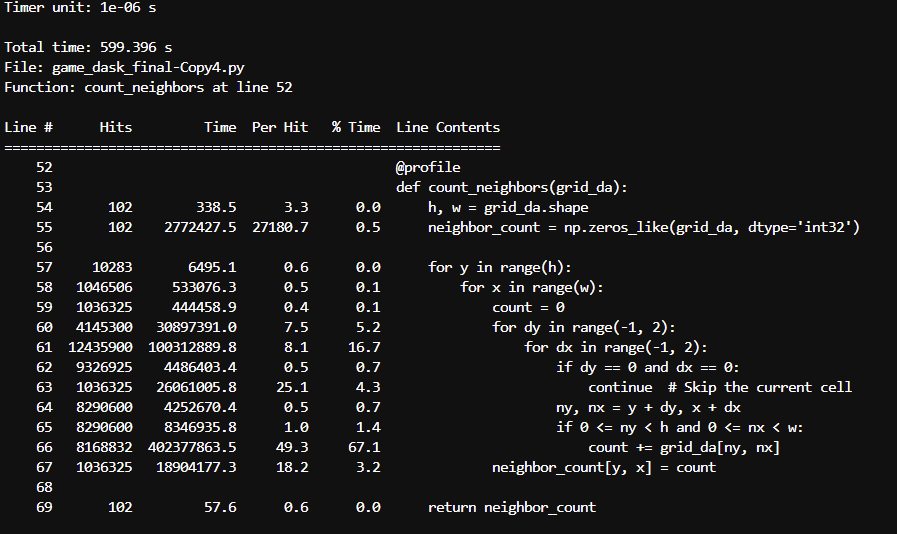
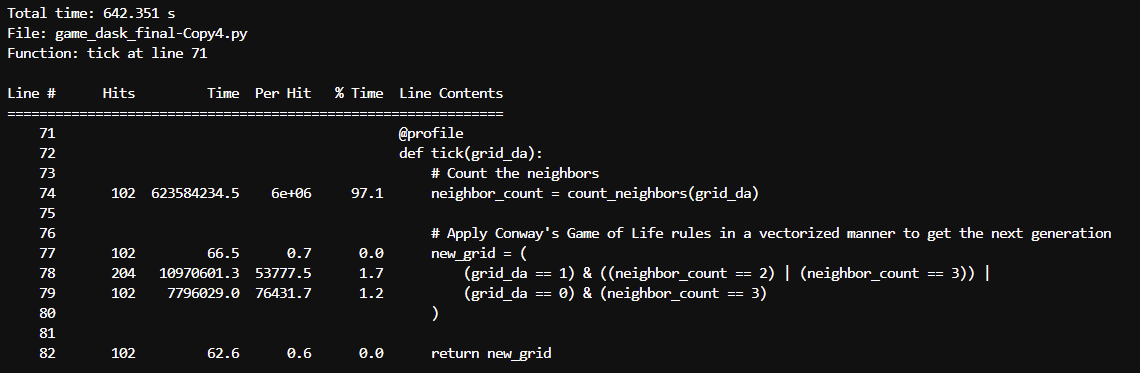


The updated code is now available, which processes the grid using smaller time units compared to the previous version. Although the efficiency in terms of Dask Threads appears insignificant, with 15.8125000 seconds of CPU Time and 64.6516044 seconds of Wall Time, there is a significant improvement in Wall time when comparing the processes and distributed implementations. The time was measured using 'time', and the results are as follows.

| Implementation  | Size       | Generation | CPU-Time              | Wall time          | Scheduler     |
|-----------------|------------|------------|-----------------------|--------------------|--------------  |
| Dask*improve    | 1000x1000  | 1          | 0.15625 seconds       | 2.3046682 seconds  | distributed    |
| Dask*improve    | 1000x1000  | 50         | 10.8593750 seconds    | 99.1596756 seconds | distributed   |
| Dask*improve    | 1000x1000  | 1          | 0.5312500 seconds     | 6.1751728 seconds  | processes     |
| Dask*improve    | 1000x1000  | 50         | 13.9843750 seconds    | 50.4781334 seconds | processes     |
| Dask*improve    | 10000x10000 | 1         | 171.9062500 seconds    | 578.4695196 seconds| threads       |
| Dask*improve    | 10000x10000 | 1          | 102.453125 seconds    | 304.0452378 seconds| processes     |
| Dask*improve    | 10000x10000 | 1          | 182.1562500 seconds   | 642.7229569 seconds| distributed   |
